In [1]:
%matplotlib inline
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
import pandas as pd
import time
from datetime import timedelta
import math
import dataset_novalid
import random
import os
import cache
import vgg16
from vgg16 import transfer_values_cache
from vgg16 import transfer_values_calc
vgg16.maybe_download()
model=vgg16.VGG16()

Data has apparently already been downloaded and unpacked.


In [2]:
classes=['0','1','2','3','4','5','6','7','8','9','A','A_LOW','B','B_LOW','C','C_LOW','D','D_LOW','E','E_LOW','F','F_LOW','G',
         'G_LOW','H','H_LOW','I','I_LOW','J','J_LOW','K','K_LOW','L','L_LOW','M','M_LOW','N','N_LOW','O','O_LOW','P','P_LOW','Q',
         'Q_LOW','R','R_LOW','S','S_LOW','T','T_LOW','U','U_LOW','V','V_LOW','W','W_LOW','X','X_LOW','Y','Y_LOW','Z','Z_LOW']
class_numbers=list(range(62))
num_classes=len(classes)
num_channels=3
img_size = 128
cache_path= 'C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST'
images_train=os.path.join(cache_path, 'images_train_2.pkl')
labels_train=os.path.join(cache_path, 'labels_train_2.pkl')
file_path_cache_train = os.path.join(cache_path, 'vgg16_train_full_pool5_2.pkl')
print("Processing VGG 16 transfer-values for training-images ...")

transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_train,
                                              model=model)

Processing VGG 16 transfer-values for training-images ...
- Data loaded from cache-file: C:/Users/Konstantin/Machine Learning/NIST Handwritten project/cache_NIST\vgg16_train_full_pool5_2.pkl


In [3]:
acc_sum=0
transfer_values_train_r=transfer_values_train.reshape(len(transfer_values_train),8192)
#transfer_values_test_r=transfer_values_test.reshape(len(test_data.test.labels),8192)
transfer_len=8192
#cls_test = np.array([label.argmax() for label in labels_test])
fc_size=2048
keep_prob=0.5
tf_reg=2e-3
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,
                 keep_prob,
                 l2_loss,
                 use_relu=True,
                use_dropout=True,
                ): 

    
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    result_loss=l2_loss*tf.nn.l2_loss(weights)
   
    layer = tf.matmul(input, weights) + biases

    
    if use_relu:
        layer = tf.nn.relu(layer)
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob)
    return layer,result_loss
def random_batch():
    
    num_images = len(transfer_values_train_r)

    
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    
    x_batch = transfer_values_train_r[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

layer_fc1,fc1_loss = new_fc_layer(input=x,
                         num_inputs=transfer_len,
                         num_outputs=fc_size,
                         l2_loss=tf_reg,
                         keep_prob=keep_prob,
                         use_relu=True,
                        use_dropout=False)
layer_fc2,fc2_loss = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         l2_loss=tf_reg,
                         keep_prob=keep_prob,
                         use_relu=True,
                        use_dropout=False)

layer_fc3,fc3_loss = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         l2_loss=tf_reg,
                         keep_prob=keep_prob,
                         use_relu=False,use_dropout=False)
y_pred = tf.nn.softmax(layer_fc3)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc3,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)+fc1_loss+fc2_loss+fc3_loss
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#feed_dict_test = {x: transfer_values_test_r,
                  #y_true: labels_test}
feed_dict_train = {x: transfer_values_train_r,
                  y_true: labels_train}
def print_accuracy_test():
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    print("Accuracy on test-set: {0:.1%}".format(acc))
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):

    cm = confusion_matrix(y_true=cls_test,  
                          y_pred=cls_pred)  

    print(cm.shape)
    for i in range(cm.shape[0]):
       
        class_name = "({}) {}".format(i, classes[i])
        print(cm[i, :], class_name)

   
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))
    
    
def plot_example_errors(cls_pred, correct):
    
    incorrect = (correct == False)
    
   
    images = images_test[incorrect]
    
    
    cls_pred = cls_pred[incorrect]

    
    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    
    # Plot the first n images.
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    
    num_images = len(transfer_values)

    
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    
    i = 0

    while i < num_images:
        
        j = min(i + batch_size, num_images)   
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}       
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)      
        i = j
        

    correct = (cls_true == cls_pred)
    print (correct)
    return correct, cls_pred
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test_r,
                       labels = labels_test,
                       cls_true = cls_test)
def classification_accuracy(correct):
    return correct.mean(), correct.sum()
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    global acc_sum
    correct, cls_pred = predict_cls_test()
    acc, num_correct = classification_accuracy(correct)
    num_images = len(correct)
    acc_sum+=acc
    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):

        ax.imshow(images[i].reshape(img_size, img_size, num_channels))


        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()
    
    
save_path='checkpoints/best_test-2'

In [4]:
session=tf.Session()
saver=tf.train.Saver()
saver.restore(session, save_path)
print("Model restored.")

INFO:tensorflow:Restoring parameters from checkpoints/best_test-2
Model restored.


Processing Batch 1
Reading test images
Loading 0 files (Index: 0)
Loading 1 files (Index: 1)
Loading 2 files (Index: 2)
Loading 3 files (Index: 3)
Loading 4 files (Index: 4)
Loading 5 files (Index: 5)
Loading 6 files (Index: 6)
Loading 7 files (Index: 7)
Loading 8 files (Index: 8)
Loading 9 files (Index: 9)
Loading A files (Index: 10)
Loading A_LOW files (Index: 11)
Loading B files (Index: 12)
Loading B_LOW files (Index: 13)
Loading C files (Index: 14)
Loading C_LOW files (Index: 15)
Loading D files (Index: 16)
Loading D_LOW files (Index: 17)
Loading E files (Index: 18)
Loading E_LOW files (Index: 19)
Loading F files (Index: 20)
Loading F_LOW files (Index: 21)
Loading G files (Index: 22)
Loading G_LOW files (Index: 23)
Loading H files (Index: 24)
Loading H_LOW files (Index: 25)
Loading I files (Index: 26)
Loading I_LOW files (Index: 27)
Loading J files (Index: 28)
Loading J_LOW files (Index: 29)
Loading K files (Index: 30)
Loading K_LOW files (Index: 31)
Loading L files (Index: 32)
Loa

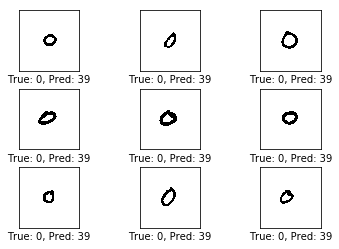

Confusion Matrix:
(62, 62)
[489   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0] (0) 0
[  0 487   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  13   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0] (1) 1
[  0   0 499   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   1] (2) 2
[  0   0   0 498   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   2   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  

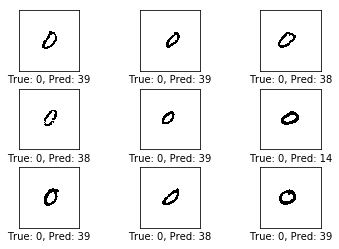

Confusion Matrix:
(62, 62)
[485   0   0   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   3  10   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0] (0) 0
[  0 488   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  12   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0] (1) 1
[  0   0 498   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   2] (2) 2
[  0   0   0 499   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  

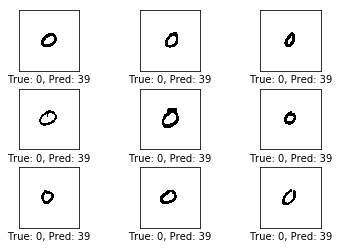

Confusion Matrix:
(62, 62)
[488   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0  12   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0] (0) 0
[  0 481   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  17   0   1   0   0   0   1   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0] (1) 1
[  0   0 496   0   0   0   0   0   0   0   0   1   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   3] (2) 2
[  0   0   0 497   0   0   0   0   0   0   0   0   0   1   0   0   0   0
   0   0   0   1   0   1   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0  

In [5]:
total_batches=3

cache_batch_path='D:/Konstantin/cache2'
for t in range(1,total_batches+1):
    
    print("Processing Batch "+str(t))
    batch_path='C:/Users/Konstantin/Machine Learning/NIST Handwritten project/batches2/batch_'+str(t)
    test_path=os.path.join(batch_path,'test')
    test_data = dataset_novalid.read_test_set(test_path, img_size,classes)
    images_test,labels_test,cls_test,ids_test=test_data.test.images,test_data.test.labels,test_data.test.cls,test_data.test.ids
    file_path_cache_test = os.path.join(cache_batch_path,'batch_'+str(t)+'.pkl')
    print("Processing VGG 16 transfer-values for test-images for batch "+str(t)+"  ...")

    transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_test,
                                             model=model)
    transfer_values_test_r=transfer_values_test.reshape(len(test_data.test.labels),8192)
    cls_test = np.array([label.argmax() for label in labels_test])
    feed_dict_test = {x: transfer_values_test_r,
                  y_true: labels_test}
    print_accuracy_test()
    print_test_accuracy(show_example_errors=True,
                        show_confusion_matrix=True)
    print('\n\n\n')

In [6]:
total_images=808564
total_correct=596296
mistakes_to_add=0